# Hamilton Load Simulation Demo

This notebook demonstrates using Hamilton to access the load simulation data and manage dataflows.

## Setup Autoreload

First, let's set up autoreload so that changes to our Hamilton dataflow modules are automatically reloaded.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime, date, timedelta
%matplotlib inline

## Import Hamilton

Now let's import Hamilton and our dataflow module.

In [2]:
from hamilton import driver

# load extension
%load_ext autoreload
# configure autoreload to only affect specified files
%autoreload 1
# import & specify my_module to be reloaded
# i.e. this is the data transformation module that I have open in other tab
%aimport feature_engineering_dataflow, modeling_dataflow, offline_etl_dataflow

/home/azureuser/localfiles/datatech-2025-demo/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [3]:
db_path = "load_simulation_results.db"
feature_store_path = "feature_store.db"
training_cutoff = pd.Timestamp(2025,5,16)

# Explorations

## Load and Explore Data

In [4]:
adapter = driver.Builder().with_modules(feature_engineering_dataflow, offline_etl_dataflow).build()
# Define the database path


In [5]:
# Execute the Hamilton dataflow to load data
result = adapter.execute(['load_data'], inputs={'db_path': db_path})
df = result['load_data']
# Display basic information
print(f"Loaded {len(df)} records from the simulation database")
print(f"Data covers from {df['pickup_date'].min()} to {df['pickup_date'].max()}")
print(f"Acceptance rate: {df['is_accepted'].mean():.1%}")

# Show a sample
df.head()

Loaded 42500 records from the simulation database
Data covers from 2025-02-03 00:00:00 to 2025-05-30 00:00:00
Acceptance rate: 3.2%


,id,pickup_date,origin_kma,origin_lat,origin_lon,destination_kma,destination_lat,destination_lon,miles,cost,weight,is_accepted
0,b259073f-c55f-402e-9f2d-f4ea8ea22eec,2025-02-03,MN_MIN,45.107102,-93.261940,AZ_PHO,33.512002,-112.071235,1497.0,3494.81,35196.0,False
1,58ab1b21-02ad-400e-ba33-a4b3a0c596cd,2025-02-03,CA_LAX,34.303815,-118.455181,TX_DAL,32.691379,-96.838933,1460.0,4129.75,27643.0,False
2,f3d6361a-82b2-4a8c-b256-3ac35e07cbd7,2025-02-03,NJ_ELI,40.536968,-74.693686,FL_LAK,28.151343,-82.081536,1115.0,2914.98,36709.0,False
3,0205a521-8c9a-4843-b96a-2e516de55e41,2025-02-03,IL_CHI,41.911865,-87.855627,CA_STK,37.934303,-121.692996,2108.0,5726.44,34731.0,False
4,93ab1b3c-a8d6-4cfe-ba28-46771662a9dd,2025-02-03,MN_MIN,44.805540,-93.341240,IL_CHI,41.641845,-87.676937,420.0,536.08,42648.0,False


In [6]:
df.sample(10)[['pickup_date', 'origin_kma', 'destination_kma', 'miles', 'cost', 'weight', 'is_accepted']]

,pickup_date,origin_kma,destination_kma,miles,cost,weight,is_accepted
38830,2025-05-21,CA_STK,CA_LAX,372.0,396.51,41764.0,False
31807,2025-05-01,NJ_ELI,AZ_PHO,2485.0,6317.02,41060.0,False
37653,2025-05-19,CA_STK,GA_ATL,2413.0,3667.78,26213.0,False
30999,2025-04-29,TX_HOU,WI_MIL,1194.0,2227.28,42292.0,False
7394,2025-02-21,WI_MIL,CA_LAX,2048.0,4715.08,28735.0,False
28771,2025-04-23,FL_LAK,CA_STK,2732.0,7636.38,37970.0,False
6918,2025-02-20,IL_CHI,WI_MIL,81.0,161.19,34085.0,False
7147,2025-02-21,TX_DAL,GA_ATL,833.0,2411.83,42874.0,False
20968,2025-04-01,FL_LAK,IL_CHI,1174.0,1095.86,33297.0,False
40907,2025-05-27,FL_LAK,CA_STK,2755.0,8187.12,40202.0,False


## Simple Features

In [10]:
training_config = {'context': 'training', 'cutoff': training_cutoff}
training_adapter = driver.Builder().with_config(training_config).with_modules(feature_engineering_dataflow, offline_etl_dataflow).build()


In [11]:
data = training_adapter.execute(['cost', 'miles'], inputs={'db_path': db_path})
data["cost"]

0        3494.81
1        4129.75
2        2914.98
3        5726.44
4         536.08
          ...   
36995    1950.54
36996    4781.87
36997     498.61
36998     674.49
36999    1087.96
Name: cost, Length: 37000, dtype: float64

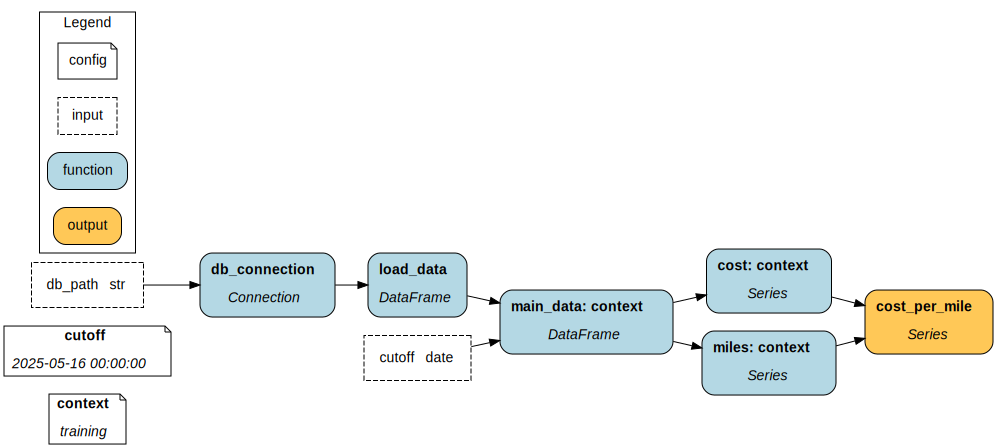

In [12]:
training_adapter.visualize_execution(['cost_per_mile'], inputs={'db_path': db_path})

# Model Training

In [13]:
features = [
    'cost',
    'miles',
    'weight',
    'cost_per_mile',
    # 'acceptance_forecast',
]
target = 'is_accepted'

## Hydrate the feature store

In [14]:
feature_store_config = {'context': 'feature_store', 'feature_store_path': feature_store_path}
feature_store_adapter = driver.Builder().with_config(feature_store_config).with_modules(feature_engineering_dataflow, offline_etl_dataflow).build()

In [15]:
feature_store_adapter.execute(['acceptance_forecast'], inputs={'db_path': db_path})

{'acceptance_forecast': None}

## Train the model

### Features

In [16]:
training_config = {'context': 'training', 'cutoff': training_cutoff}
training_inputs = {'db_path': db_path, 'feature_store_path': feature_store_path}
training_adapter = driver.Builder().with_config(training_config).with_modules(feature_engineering_dataflow, offline_etl_dataflow).build()


In [17]:
training_features_df = pd.DataFrame(training_adapter.execute(features, inputs=training_inputs))
training_target_df = pd.DataFrame(training_adapter.execute([target], inputs=training_inputs))

### Model

In [18]:
model_training_config = {'context': 'training', 'hyperparams': None, 'model_file_path': 'model.pkl'}
model_training_inputs = {'features_df': training_features_df, 'target_df': training_target_df}
model_training_adapter = driver.Builder().with_config(model_training_config).with_modules(modeling_dataflow).build()


In [19]:
model_training_adapter.execute(['save_model'], inputs=model_training_inputs)

{'save_model': {}}

# Model evaluation

In [20]:
test_config = {'context': 'testing', 'cutoff': training_cutoff}
test_inputs = {'db_path': db_path, 'feature_store_path': feature_store_path}
test_adapter = driver.Builder().with_config(test_config).with_modules(feature_engineering_dataflow, offline_etl_dataflow).build()
test_features_df = pd.DataFrame(test_adapter.execute(features, inputs=test_inputs))
test_target_df = pd.DataFrame(test_adapter.execute([target], inputs=test_inputs))

In [21]:
model_evaluation_config = {'context': 'testing', 'model_file_path': 'model.pkl', 'prediction_threshold': 0.5}
model_evaluation_inputs = {'features_df': test_features_df, 'target_df': test_target_df}
model_evaluation_adapter = driver.Builder().with_config(model_evaluation_config).with_modules(modeling_dataflow).build()


Accuracy: 96.9%
Precision: 50.0%
Recall: 4.7%


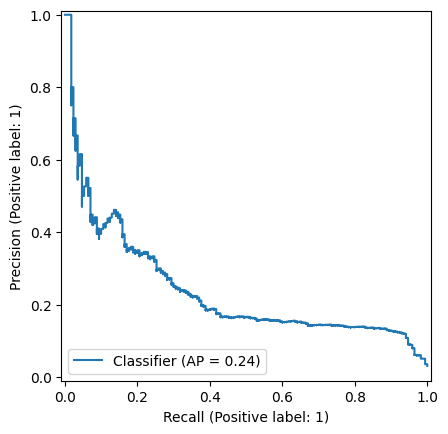

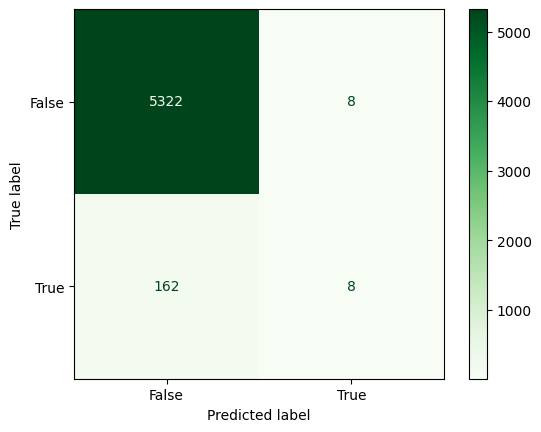

In [22]:
metrics = [
    'accuracy',
    'precision',
    'recall',
    'precision_recall_curve',
    'confusion_matrix',
]
model_evaluation_results = model_evaluation_adapter.execute(metrics, inputs=model_evaluation_inputs)